# Logistic Regression

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ml2019spring-hw2/test.csv
/kaggle/input/ml2019spring-hw2/train.csv
/kaggle/input/ml2019spring-hw2/X_train
/kaggle/input/ml2019spring-hw2/sample_submission.csv
/kaggle/input/ml2019spring-hw2/Y_train
/kaggle/input/ml2019spring-hw2/X_test


In [2]:
np.log(np.clip(np.array([[0, 1, 2], [0, 1, 2]]), 1e-6, None))

array([[-13.81551056,   0.        ,   0.69314718],
       [-13.81551056,   0.        ,   0.69314718]])

In [3]:
def _normalize_column_normal(X, train=True, specified_column = None, X_mean=None, X_std=None):
    # The output of the function will make the specified column number to 
    # become a Normal distribution
    # When processing testing data, we need to normalize by the value 
    # we used for processing training, so we must save the mean value and 
    # the variance of the training data
    if train:
        if specified_column == None:
            specified_column = np.arange(X.shape[1])
        length = len(specified_column)
        #log
        #X[:,specified_column] = np.log(np.clip(X[:,specified_column], 1e-6, None))
        X_mean = np.reshape(np.mean(X[:, specified_column],0), (1, length))
        X_std  = np.reshape(np.std(X[:, specified_column], 0), (1, length))
    X[:,specified_column] = np.divide(np.subtract(X[:,specified_column],X_mean), X_std)
     
    return X, X_mean, X_std

def _shuffle(X, Y):
    randomize = np.arange(len(X))
    np.random.shuffle(randomize)
    return (X[randomize], Y[randomize])
    
def train_dev_split(X, y, dev_size=0.25):
    train_len = int(round(len(X)*(1-dev_size)))
    return X[0:train_len], y[0:train_len], X[train_len:None], y[train_len:None]

def _sigmoid(z):
    # sigmoid function can be used to output probability
    return np.clip(1 / (1.0 + np.exp(-z)), 1e-6, 1-1e-6)

def get_prob(X, w, b):
    # the probability to output 1
    return _sigmoid(np.add(np.matmul(X, w), b))

def infer(X, w, b):
    # use round to infer the result
    return np.round(get_prob(X, w, b))

def _cross_entropy(y_pred, Y_label):
    # compute the cross entropy
    cross_entropy = -np.dot(Y_label, np.log(y_pred))-np.dot((1-Y_label), np.log(1-y_pred))
    return cross_entropy

def _gradient(X, Y_label, w, b):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _gradient_regularization(X, Y_label, w, b, lamda):
    # return the mean of the graident
    y_pred = get_prob(X, w, b)
    pred_error = Y_label - y_pred
    w_grad = -np.mean(np.multiply(pred_error.T, X.T), 1)+lamda*w
    b_grad = -np.mean(pred_error)
    return w_grad, b_grad

def _loss(y_pred, Y_label, lamda, w):
    return _cross_entropy(y_pred, Y_label) + lamda * np.sum(np.square(w))

def accuracy(Y_pred, Y_label):
    acc = np.sum(Y_pred == Y_label)/len(Y_pred)
    return acc

def train(X_train, Y_train):
    # split a validation set
    dev_size = 0.1155
    X_train, Y_train, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = dev_size)
    
    # Use 0 + 0*x1 + 0*x2 + ... for weight initialization
    w = np.zeros((X_train.shape[1],)) 
    b = np.zeros((1,))

    regularize = False#True
    if regularize:
        lamda = 0.001
    else:
        lamda = 0
    
    max_iter = 100  # max iteration number
    batch_size = 32 # number to feed in the model for average to avoid bias
    learning_rate = 0.2  # how much the model learn for each step
    num_train = len(Y_train)
    num_dev = len(Y_dev)
    step =1

    loss_train = []
    loss_validation = []
    train_acc = []
    dev_acc = []
    
    for epoch in range(max_iter):
        # Random shuffle for each epoch
        X_train, Y_train = _shuffle(X_train, Y_train)
        
        total_loss = 0.0
        # Logistic regression train with batch
        for idx in range(int(np.floor(len(Y_train)/batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]
            
            # Find out the gradient of the loss
            w_grad, b_grad = _gradient_regularization(X, Y, w, b, lamda)
            
            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad
            
            step = step+1
            
        # Compute the loss and the accuracy of the training set and the validation set
        y_train_pred = get_prob(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)
        train_acc.append(accuracy(Y_train_pred, Y_train))
        loss_train.append(_loss(y_train_pred, Y_train, lamda, w)/num_train)
        
        y_dev_pred = get_prob(X_dev, w, b)
        Y_dev_pred = np.round(y_dev_pred)
        dev_acc.append(accuracy(Y_dev_pred, Y_dev))
        loss_validation.append(_loss(y_dev_pred, Y_dev, lamda, w)/num_dev)
    
    return w, b, loss_train, loss_validation, train_acc, dev_acc  # return loss for plotting

In [4]:
def data_process(path):
    raw_data = pd.read_csv(path)
    raw_data[raw_data == ' ?'] = np.nan
    if path.split('/')[-1].split('.')[0] == 'train':
        for i in range(len(raw_data)):
            if raw_data['income'][i] == ' <=50K':
                raw_data.at[i, 'income'] = 0
            elif raw_data['income'][i] == ' >50K':
                raw_data.at[i, 'income'] = 1
            else:
                print(i)
    for i in range(len(raw_data)):
        if raw_data['fnlwgt'][i] < 100000:
            raw_data.at[i, 'fnlwgt_range'] = '0~100k'
        elif raw_data['fnlwgt'][i] >= 100000 and raw_data['fnlwgt'][i] < 200000:
            raw_data.at[i, 'fnlwgt_range'] = '100k~200k'
        elif raw_data['fnlwgt'][i] >= 200000 and raw_data['fnlwgt'][i] < 300000:
            raw_data.at[i, 'fnlwgt_range'] = '200k~300k'
        elif raw_data['fnlwgt'][i] >= 300000 and raw_data['fnlwgt'][i] < 400000:
            raw_data.at[i, 'fnlwgt_range'] = '300k~400k'
        else:
            raw_data.at[i, 'fnlwgt_range'] = '>400k'
    raw_data.drop('fnlwgt', axis = 1, inplace = True)
    raw_data = pd.get_dummies(raw_data)
    if path.split('/')[-1].split('.')[0] == 'train':
        raw_data.drop('income_0', axis = 1, inplace = True)
        raw_data = raw_data.rename(columns={"income_1": "income"})
        X = raw_data.drop('income', axis = 1)#.to_numpy().astype(float)
        Y = raw_data['income'].to_numpy()
        return X, Y
    else:
        X = raw_data#.to_numpy().astype(float)
        return X

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


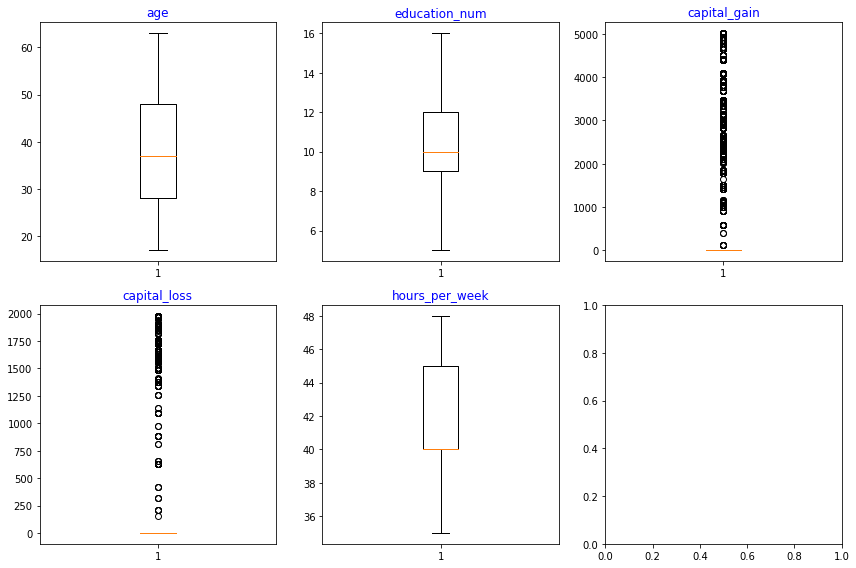

In [6]:
from scipy.stats.mstats import winsorize
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
X_train['age'] = winsorize(X_train['age'], limits=[0, 0.05]).filled()
X_train['education_num'] = winsorize(X_train['education_num'], limits=[0.05, 0]).filled()
X_train['capital_gain'] = winsorize(X_train['capital_gain'], limits=[0, 0.05]).filled()
X_train['capital_loss'] = winsorize(X_train['capital_loss'], limits=[0, 0.01]).filled()
X_train['hours_per_week'] = winsorize(X_train['hours_per_week'], limits=[0.2, 0.2]).filled()
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            continue
        axes[i , j].boxplot(X_train[X_train.columns[i * 3 + j]])
        axes[i , j].set_title(X_train.columns[i * 3 + j], color="b", fontsize=12)
plt.tight_layout()
plt.show()

In [7]:
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
X_train['age'] = winsorize(X_train['age'], limits=[0, 0.05]).filled()
#X_train['education_num'] = winsorize(X_train['education_num'], limits=[0.05, 0]).filled()
#X_train['capital_gain'] = winsorize(X_train['capital_gain'], limits=[0, 0.05]).filled()
#X_train['capital_loss'] = winsorize(X_train['capital_loss'], limits=[0, 0.01]).filled()
X_train['hours_per_week'] = winsorize(X_train['hours_per_week'], limits=[0.2, 0.2]).filled()
X_train = X_train.to_numpy().astype(float)
#normalization
col = [0, 1, 2, 3, 4]
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)

In [8]:
w, b, loss_train, loss_validation, train_acc, dev_acc= train(X_train, Y_train)

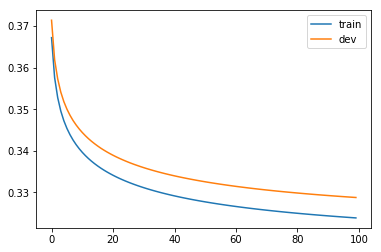

In [9]:
plt.plot(loss_train)
plt.plot(loss_validation)
plt.legend(['train', 'dev'])
plt.show()

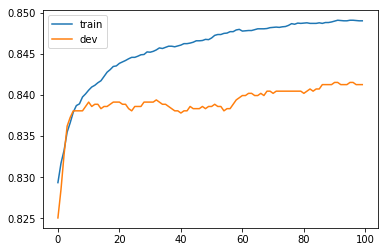

In [10]:
plt.plot(train_acc)
plt.plot(dev_acc)
plt.legend(['train', 'dev'])
plt.show()

In [11]:
X_test = data_process('../input/ml2019spring-hw2/test.csv')
X_test['native_country_ Holand-Netherlands'] = 0
X_test['age'] = winsorize(X_test['age'], limits=[0, 0.1]).filled()
#X_test['education_num'] = winsorize(X_test['education_num'], limits=[0.05, 0]).filled()
#X_test['capital_gain'] = winsorize(X_test['capital_gain'], limits=[0, 0.05]).filled()
#X_test['capital_loss'] = winsorize(X_test['capital_loss'], limits=[0, 0.01]).filled()
X_test['hours_per_week'] = winsorize(X_test['hours_per_week'], limits=[0.2, 0.2]).filled()
X_test = X_test.to_numpy().astype(float)
#normalization
col = [0, 1, 2, 3, 4]
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

In [12]:
result = infer(X_test, w, b)

In [13]:
with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(result):
            f.write('%d,%d\n' %(i+1, v))

without normalizing => 0.80638

normalizing col == None => 0.82334  
normalizing col == [0, 1, 2, 3, 4] => 0.84643 

winsorizing => 0.85196  
winsorizing and regularizing => 0.85159

In [14]:
ind = np.argsort(np.abs(w))[::-1]
features = data_process('../input/ml2019spring-hw2/test.csv').columns
for i in ind[0:10]:
    print(features[i], w[i])

capital_gain 1.5381840582708155
marital_status_ Married-civ-spouse 0.8532434249153495
marital_status_ Never-married -0.8199459139737779
education_num 0.7244392584063196
relationship_ Wife 0.6913129149094697
relationship_ Own-child -0.6173159157003857
sex_ Female -0.565004608879763
occupation_ Exec-managerial 0.5206950068083619
relationship_ Unmarried -0.48607116875203943
occupation_ Other-service -0.4711700655257332


# Probabilistic Generative Model

In [15]:
import numpy as np
import sys
import csv  
from numpy.linalg import inv

In [16]:
def find_theta(X_train, Y_train, X_test = None):
    class_0_id = []
    class_1_id = []
    for i in range(Y_train.shape[0]):
        if Y_train[i] == 0:
            class_0_id.append(i)
        else:
            class_1_id.append(i)
    
    class_0 = X_train[class_0_id]
    class_1 = X_train[class_1_id] 

    mean_0 = np.mean(class_0,axis = 0)
    mean_1 = np.mean(class_1,axis = 0)  

    n = class_0.shape[1]
    cov_0 = np.zeros((n,n))
    cov_1 = np.zeros((n,n))

    for i in range(class_0.shape[0]):
        cov_0 += np.dot(np.transpose([class_0[i] - mean_0]), [(class_0[i] - mean_0)]) / class_0.shape[0]

    for i in range(class_1.shape[0]):
        cov_1 += np.dot(np.transpose([class_1[i] - mean_1]), [(class_1[i] - mean_1)]) / class_1.shape[0]

    cov = (cov_0*class_0.shape[0] + cov_1*class_1.shape[0]) / (class_0.shape[0] + class_1.shape[0])

    w = np.transpose(((mean_0 - mean_1)).dot(inv(cov)) )
    b =  (- 0.5)* (mean_0).dot(inv(cov)).dot(mean_0)\
        + 0.5 * (mean_1).dot(inv(cov)).dot(mean_1)\
        + np.log(float(class_0.shape[0]) / class_1.shape[0]) 

    result = func(X_train, w, b)
    answer = predict(result)
    
    if X_test.shape == None:
        return answer
    else:
        result = func(X_test, w, b)
        answer = predict(result)
        return answer


def func(x, w, b):
    arr = np.empty([x.shape[0],1],dtype=float)
    for i in range(x.shape[0]):
        z = x[i,:].dot(w) + b
        z *= (-1)
        arr[i][0] = 1 / (1 + np.exp(z))
    return np.clip(arr, 1e-8, 1-(1e-8))

def predict(x):
    ans = np.ones([x.shape[0],1],dtype=int)
    for i in range(x.shape[0]):
        if x[i] > 0.5:
            ans[i] = 0; 
    return ans

In [17]:
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
X_train['age'] = winsorize(X_train['age'], limits=[0, 0.05]).filled()
#X_train['education_num'] = winsorize(X_train['education_num'], limits=[0, 0.05]).filled()
#X_train['capital_gain'] = winsorize(X_train['capital_gain'], limits=[0, 0.05]).filled()
#X_train['capital_loss'] = winsorize(X_train['capital_loss'], limits=[0, 0.05]).filled()
X_train['hours_per_week'] = winsorize(X_train['hours_per_week'], limits=[0.2, 0.2]).filled()
X_train = X_train.to_numpy().astype(float)
#normalization
col = None # if use [0, 1, 2, 3, 4], all the prediction will be 0 (why?)
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)

In [18]:
X_test = data_process('../input/ml2019spring-hw2/test.csv')
X_test['native_country_ Holand-Netherlands'] = 0
X_test['age'] = winsorize(X_test['age'], limits=[0, 0.1]).filled()
#X_test['education_num'] = winsorize(X_test['education_num'], limits=[0, 0.05]).filled()
#X_test['capital_gain'] = winsorize(X_test['capital_gain'], limits=[0, 0.05]).filled()
#X_test['capital_loss'] = winsorize(X_test['capital_loss'], limits=[0, 0.05]).filled()
X_test['hours_per_week'] = winsorize(X_test['hours_per_week'], limits=[0.2, 0.2]).filled()
X_test = X_test.to_numpy().astype(float)
#normalization
col = None
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

In [19]:
answer = find_theta(X_train, Y_train, X_test)
answer.shape

(16281, 1)

In [20]:
with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(answer):
            f.write('%d,%d\n' %(i+1, v))

=> 0.83599
after winsorizing => 0.83660

# ohter models

In [21]:
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
X_train['age'] = winsorize(X_train['age'], limits=[0, 0.05]).filled()
#X_train['education_num'] = winsorize(X_train['education_num'], limits=[0, 0.05]).filled()
#X_train['capital_gain'] = winsorize(X_train['capital_gain'], limits=[0, 0.05]).filled()
#X_train['capital_loss'] = winsorize(X_train['capital_loss'], limits=[0, 0.05]).filled()
X_train['hours_per_week'] = winsorize(X_train['hours_per_week'], limits=[0.2, 0.2]).filled()
X_train = X_train.to_numpy().astype(float)
#normalization
col = None
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)
X_test = data_process('../input/ml2019spring-hw2/test.csv')
X_test['native_country_ Holand-Netherlands'] = 0
X_test['age'] = winsorize(X_test['age'], limits=[0, 0.1]).filled()
#X_test['education_num'] = winsorize(X_test['education_num'], limits=[0, 0.05]).filled()
#X_test['capital_gain'] = winsorize(X_test['capital_gain'], limits=[0, 0.05]).filled()
#X_test['capital_loss'] = winsorize(X_test['capital_loss'], limits=[0, 0.05]).filled()
X_test['hours_per_week'] = winsorize(X_test['hours_per_week'], limits=[0.2, 0.2]).filled()
X_test['native_country_ Holand-Netherlands'] = 0
X_test = X_test.to_numpy().astype(float)
#normalization
col = None
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
X, Y, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = 0.2)
# CV model
rf = RandomForestClassifier(max_depth=15, random_state=0)
rf.fit(X_train, Y_train)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(rf, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 85.70% (0.46%)


In [23]:
answer = rf.predict(X_test).reshape(-1, 1)
with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(answer):
            f.write('%d,%d\n' %(i+1, v))

RandomForest => 0.85122  
afer winsorizing => 0.86265

In [24]:
from xgboost import XGBClassifier
xgbc = XGBClassifier()
xgbc.fit(X_train, Y_train)
answer = xgbc.predict(X_test).reshape(-1, 1)

In [25]:
with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(answer):
            f.write('%d,%d\n' %(i+1, v))

xgboost => 0.86781  
after winsorizing => 0.86818

In [26]:
# k-fold cross validation evaluation of xgboost model
from numpy import loadtxt
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
X, Y, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = 0.2)
# CV model
model = xgboost.XGBClassifier()
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(model, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 86.35% (0.34%)


In [27]:
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
X_train['age'] = winsorize(X_train['age'], limits=[0, 0.05]).filled()
#X_train['education_num'] = winsorize(X_train['education_num'], limits=[0, 0.05]).filled()
#X_train['capital_gain'] = winsorize(X_train['capital_gain'], limits=[0, 0.05]).filled()
#X_train['capital_loss'] = winsorize(X_train['capital_loss'], limits=[0, 0.05]).filled()
X_train['hours_per_week'] = winsorize(X_train['hours_per_week'], limits=[0.2, 0.2]).filled()
X_train = X_train.to_numpy().astype(float)
#normalization
col = None
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)
X_test = data_process('../input/ml2019spring-hw2/test.csv')
X_test['native_country_ Holand-Netherlands'] = 0
X_test['age'] = winsorize(X_test['age'], limits=[0, 0.1]).filled()
#X_test['education_num'] = winsorize(X_test['education_num'], limits=[0, 0.05]).filled()
#X_test['capital_gain'] = winsorize(X_test['capital_gain'], limits=[0, 0.05]).filled()
#X_test['capital_loss'] = winsorize(X_test['capital_loss'], limits=[0, 0.05]).filled()
X_test['hours_per_week'] = winsorize(X_test['hours_per_week'], limits=[0.2, 0.2]).filled()
X_test['native_country_ Holand-Netherlands'] = 0
X_test = X_test.to_numpy().astype(float)
#normalization
col = None
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [28]:
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
X, Y, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = 0.2)
# CV model
cat = CatBoostClassifier(learning_rate=0.04)
cat.fit(X_train, Y_train)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(cat, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

0:	learn: 0.6524946	total: 82ms	remaining: 1m 21s
1:	learn: 0.6162523	total: 103ms	remaining: 51.3s
2:	learn: 0.5855662	total: 119ms	remaining: 39.6s
3:	learn: 0.5549054	total: 135ms	remaining: 33.6s
4:	learn: 0.5289429	total: 153ms	remaining: 30.4s
5:	learn: 0.5072218	total: 170ms	remaining: 28.2s
6:	learn: 0.4879523	total: 186ms	remaining: 26.4s
7:	learn: 0.4692377	total: 204ms	remaining: 25.3s
8:	learn: 0.4546278	total: 223ms	remaining: 24.5s
9:	learn: 0.4396561	total: 240ms	remaining: 23.8s
10:	learn: 0.4274336	total: 257ms	remaining: 23.1s
11:	learn: 0.4175581	total: 274ms	remaining: 22.5s
12:	learn: 0.4090464	total: 293ms	remaining: 22.3s
13:	learn: 0.4003183	total: 309ms	remaining: 21.8s
14:	learn: 0.3932909	total: 324ms	remaining: 21.3s
15:	learn: 0.3874231	total: 340ms	remaining: 20.9s
16:	learn: 0.3819282	total: 356ms	remaining: 20.6s
17:	learn: 0.3771933	total: 371ms	remaining: 20.3s
18:	learn: 0.3717561	total: 387ms	remaining: 20s
19:	learn: 0.3667559	total: 403ms	remaining

In [29]:
answer = cat.predict(X_test).reshape(-1, 1)
with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(answer):
            f.write('%d,%d\n' %(i+1, v))

catboost => 0.8426

In [30]:
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
X_train['age'] = winsorize(X_train['age'], limits=[0, 0.05]).filled()
#X_train['education_num'] = winsorize(X_train['education_num'], limits=[0, 0.05]).filled()
#X_train['capital_gain'] = winsorize(X_train['capital_gain'], limits=[0, 0.05]).filled()
#X_train['capital_loss'] = winsorize(X_train['capital_loss'], limits=[0, 0.05]).filled()
X_train['hours_per_week'] = winsorize(X_train['hours_per_week'], limits=[0.2, 0.2]).filled()
X_train = X_train.to_numpy().astype(float)
#normalization
col = None
X_train, X_mean, X_std = _normalize_column_normal(X_train, specified_column=col)
X_test = data_process('../input/ml2019spring-hw2/test.csv')
X_test['native_country_ Holand-Netherlands'] = 0
X_test['age'] = winsorize(X_test['age'], limits=[0, 0.1]).filled()
#X_test['education_num'] = winsorize(X_test['education_num'], limits=[0, 0.05]).filled()
#X_test['capital_gain'] = winsorize(X_test['capital_gain'], limits=[0, 0.05]).filled()
#X_test['capital_loss'] = winsorize(X_test['capital_loss'], limits=[0, 0.05]).filled()
X_test['hours_per_week'] = winsorize(X_test['hours_per_week'], limits=[0.2, 0.2]).filled()
X_test['native_country_ Holand-Netherlands'] = 0
X_test = X_test.to_numpy().astype(float)
#normalization
col = None
X_test, _, _= _normalize_column_normal(X_test, train=False, specified_column = col, X_mean=X_mean, X_std=X_std)

In [31]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
X, Y, X_dev, Y_dev = train_dev_split(X_train, Y_train, dev_size = 0.2)
# CV model
lgbc = LGBMClassifier(boosting_type='gbdt', objective='binary', num_leaves=15, learning_rate=0.1)
lgbc.fit(X_train, Y_train)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(lgbc, X, Y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 87.22% (0.29%)


In [32]:
answer = lgbc.predict(X_test).reshape(-1, 1)
with open('submission.csv', 'w') as f:
        f.write('id,label\n')
        for i, v in  enumerate(answer):
            f.write('%d,%d\n' %(i+1, v))

lgbm => 0.87444

# feature importence

xgbootst importance

/opt/conda/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


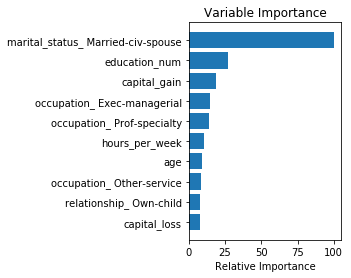

In [33]:
model.fit(X_train, Y_train)
X_train, Y_train = data_process('../input/ml2019spring-hw2/train.csv')
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-10:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], align='center')
#plt.yticks(pos, ['Intercept'] + [X_train.columns[i-1] for i in sorted_idx[1:][:10]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

logistic regression weight 大小

<BarContainer object of 10 artists>

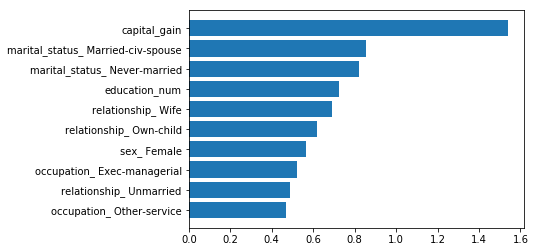

In [34]:
plt.barh(X_train.columns[np.argsort(np.abs(w))[-10:]], np.abs(w)[np.argsort(np.abs(w))[-10:]], align='center')

Text(0.5, 1.0, 'capital_gain = 0')

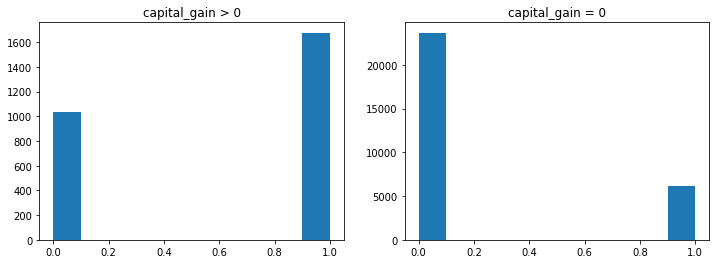

In [35]:
fig, axes =  plt.subplots(1, 2, figsize=(12,4))
axes[0].hist(Y_train[X_train[X_train['capital_gain'] > 0].index])
axes[0].set_title('capital_gain > 0')
axes[1].hist(Y_train[X_train[X_train['capital_gain'] == 0].index])
axes[1].set_title('capital_gain = 0')

# HW2_report

1. 請比較你實作的generative model、logistic regression 的準確率，何者較佳？  
    0.83660 v.s. 0.85196 , logistic regression較佳
2. 請說明你實作的best model，其訓練方式和準確率為何？  
    使用logistic regression，batch數為32，iter數為100，不使用regularization
3. 請實作輸入特徵標準化(feature normalization)並討論其對於你的模型準確率的影響  
    0.80638 -> 0.85196 
4. 請實作logistic regression 的正規化(regularization)，並討論其對於你的模型準確率的影響。
    0.85196 -> 0.85159
5. 請討論你認為哪個attribute 對結果影響最大？  
    capital_gain